# Training of the movement of a chaotic pendulum using the LSTM model

---

In diesem Notebook wird die Vohersage..

## Install all necessary requirements

In [1]:
!pip install -q -r ../requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!nvidia-smi

Sat Jan 27 14:05:17 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   61C    P8    16W /  N/A |   1666MiB /  6144MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf

sequence_length = 50
output_length = 200
batch_size = 128
epochs = 1

layers = 2
units = [128,64]

folder_path = r"C:\Users\Marco\dev\git\proj-chaotic-pendulum\src\timeseries_forecasting\data\processed"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
def load_data_from_csv(path: str):
    return pd.read_csv(path, delimiter=",")

In [5]:
def get_file_names(folder_path: str):
    # Check if the folder path exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Error: Folder '{folder_path}' does not exist.")

    # Get a list of all files in the folder
    return [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

file_names = get_file_names(folder_path)

x_list = []
y_list = []
x = None
y = None
for file in file_names:
    data = load_data_from_csv(file)
    if len(data) >= sequence_length + output_length:
        # Convert angles to sine and cosine values
        data['Sin_Angle1'] = np.sin(data['Angle1'])
        data['Cos_Angle1'] = np.cos(data['Angle1'])

        data['Sin_Angle2'] = np.sin(data['Angle2'])
        data['Cos_Angle2'] = np.cos(data['Angle2'])

        sin_angle1 = data["Sin_Angle1"].to_numpy()
        cos_angle1 = data["Cos_Angle1"].to_numpy()

        sin_angle2 = data["Sin_Angle2"].to_numpy()
        cos_angle2 = data["Cos_Angle2"].to_numpy()

        numpy_data = np.column_stack((sin_angle1, cos_angle1, sin_angle2, cos_angle2))
        # print("DATA SHAPE: {}".format(numpy_data.shape))

        x_sample = numpy_data[:sequence_length]
        y_sample = numpy_data[sequence_length:sequence_length + output_length].flatten()

        x_list.append(x_sample)
        y_list.append(y_sample)

        if isinstance(x, np.ndarray):
            x = np.concatenate((x, np.array(x_list)))
            y = np.concatenate((y, np.array(y_list)))
        else:
            x = np.array(x_list)
            y = np.array(y_list)

print("DATA SHAPE AFTER: {}, {}".format(x.shape, y.shape))

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25,
                                                    random_state=1)  # 0.25 x 0.8 = 0.2

DATA SHAPE AFTER: (105570, 50, 4), (105570, 800)


In [7]:
def reconstruct_radian(sin_value, cos_value):
    return np.arctan2(sin_value, cos_value)

In [8]:
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Bidirectional
from tensorflow.keras.callbacks import TensorBoard
from tensorflow import keras
import matplotlib.pyplot as plt

import datetime

%matplotlib inline

class RNNModel:
    def __init__(self, inputs, outputs, layers=1, units=None, model_path=None, input_shape=4):
        if model_path:
            self.model = keras.models.load_model(model_path)
            return
        self.input_shape = input_shape
        self.construct_network(inputs, outputs, layers=layers, units=units)

    def construct_network(self, inputs, outputs, layers=1, units=None):
        first_lstm = True
        # Build the RNN model
        if units is None:
            units = [32]

        model_input = keras.layers.Input((inputs, self.input_shape))
        x = model_input

        for l in range(layers):
            x = Bidirectional(LSTM(units[l], activation='relu', return_sequences=(first_lstm and layers > 1)))(x)
            x = BatchNormalization()(x)
            x = Dropout(0.25)(x)
            first_lstm = False

        x = Dense(2 * units[0], activation='relu')(x)
        model_output = Dense(self.input_shape * outputs)(x)

        self.model = keras.Model(inputs=model_input, outputs=model_output)
        self.model.summary()

        self.model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    def train_model(self, x_train, x_val, y_train, y_val, epochs=100, batch_size=32):
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S_rnn_model")
        path_checkpoint = f"./model_checkpoints/{timestamp}_rnn_model.h5"
        path_tensorboard = f"./logs/{timestamp}_rnn_model"
        early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)

        checkpoint = keras.callbacks.ModelCheckpoint(
            monitor="val_loss",
            filepath=path_checkpoint,
            verbose=1,
            save_weights_only=False,
            save_best_only=True,
        )

        # Create a TensorBoard callback
        tensorboard_callback = TensorBoard(log_dir=path_tensorboard)

        # Train the model
        history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val),
                                 callbacks=[checkpoint, tensorboard_callback, early_stopping])

        return history

    def evaluate_model(self, x_test, y_test, sequence_length, output_length, number_of_plots):
        # Evaluate the model
        loss = self.model.evaluate(x_test, y_test)
        print("Test Loss:", loss)
        plots = 0
        for x_sample, y_sample in zip(x_test, y_test):
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            time_array = np.array(range(sequence_length))
            y_pred = self.model.predict(np.expand_dims(x_sample, axis=0)).reshape(-1, 4)
            y_sample = y_sample.reshape(-1, 4)
            axes[0].plot(time_array, reconstruct_radian(x_sample[:, 0], x_sample[:, 1]), label="Input Sequence",
                         linestyle='-', marker='o')
            axes[0].plot(list(range(sequence_length, sequence_length + output_length)),
                         reconstruct_radian(y_pred[:, 0], y_pred[:, 1]),
                         label="Prediction", linestyle='-', marker='o')
            axes[0].plot(list(range(sequence_length, sequence_length + output_length)),
                         reconstruct_radian(y_sample[:, 0], y_sample[:, 1]),
                         label="Ground Truth", linestyle='-', marker='o')
            axes[0].set_title("Arm 1")
            axes[0].set_ylim([-3.2, 3.2])
            axes[0].legend()
            axes[0].grid(visible=True)

            axes[1].plot(time_array, reconstruct_radian(x_sample[:, 2], x_sample[:, 3]), label="Input Sequence",
                         linestyle='-', marker='o')
            axes[1].plot(list(range(sequence_length, sequence_length + output_length)),
                         reconstruct_radian(y_pred[:, 2], y_pred[:, 3]),
                         label="Prediction", linestyle='-', marker='o')
            axes[1].plot(list(range(sequence_length, sequence_length + output_length)),
                         reconstruct_radian(y_sample[:, 2], y_sample[:, 3]),
                         label="Ground Truth", linestyle='-', marker='o')
            axes[1].set_title("Arm 2")
            axes[1].set_ylim([-3.2, 3.2])
            axes[1].legend()
            axes[1].grid(visible=True)

            plt.show()

            if plots == number_of_plots-1:
                break
            plots=plots+1

In [9]:
from tensorflow import keras

model = RNNModel(sequence_length, output_length, layers=layers, units=units,
                 model_path=None)

model.train_model(x_train, x_val, y_train, y_val, epochs, batch_size)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 4)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          136192    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 50, 256)          1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                             

660/660 [==============================] - 80s 121ms/step - loss: 0.3806 - mse: 0.3806
Test Loss: [0.38060688972473145, 0.38060688972473145]
1/1 [==============================] - 0s 495ms/step


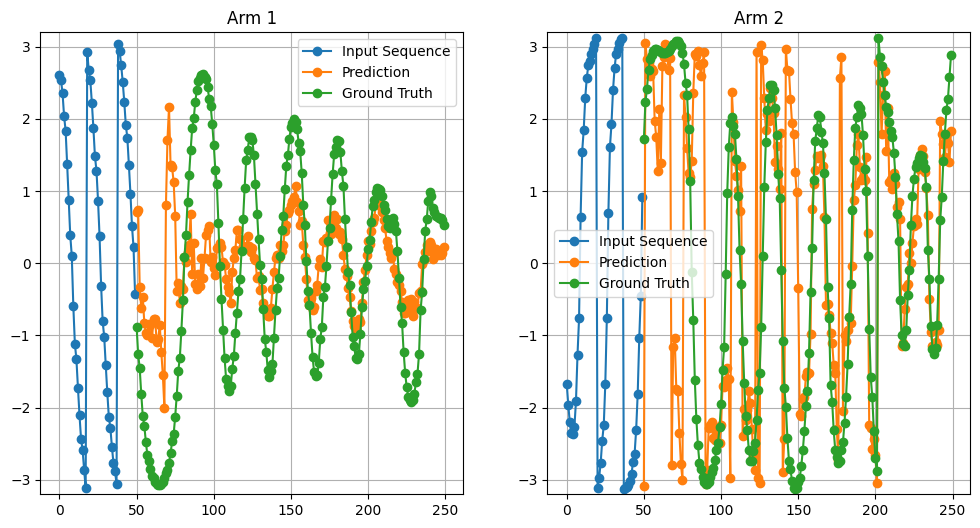

1/1 [==============================] - 0s 103ms/step


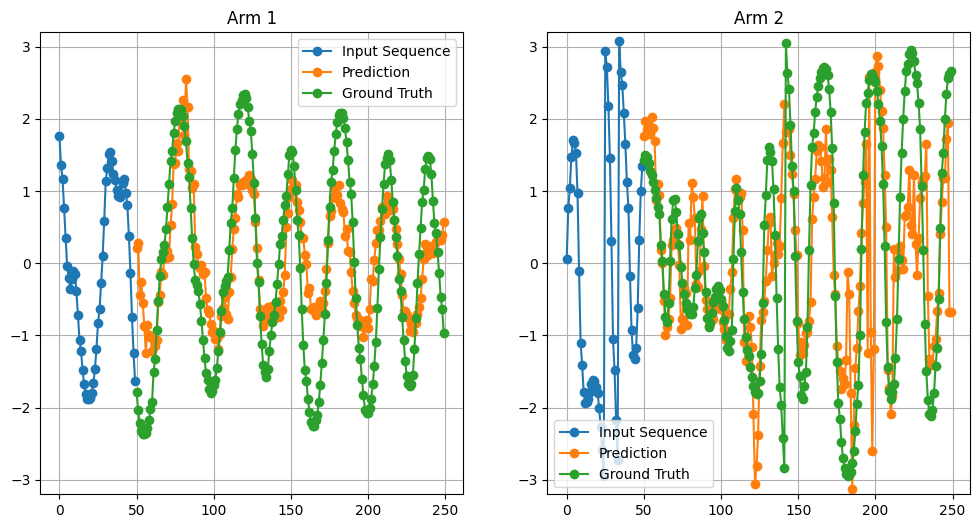

In [10]:
model.evaluate_model(x_test, y_test, sequence_length, output_length, number_of_plots=2)